https://zenn.dev/joanofarc/articles/gradient-boosting-interval-prediction

In [2]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 11.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 17.0 MB/s eta 0:00:0000:0100:01
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_11_0_arm64.whl (63 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.2 MB/s eta 0:00:0000:0100:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.8 MB/s eta 0:00:00
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=a5eded16cb7c3c78f3fa257c0ffcd5d13a6c4b475e120f6187252a917e6b44b0
  Stored in directory: /Users/ykondo/Library/Caches/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize-matplotlib

[notice] A new release of pip available: 22.2.2 -> 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns

In [9]:
np.random.seed(1)
num_of_sample = 3000

x = np.random.uniform(low=-5, high=5, size=num_of_sample)

# 後のmatplotlibを用いた描画に備えて小さい順に並び替えておく。そうしないと描画がぐちゃぐちゃになる。
x = np.sort(x)

# ground truth (真の値) は sin カーブであるとする。
ground_truth = np.sin(x)
# 目的変数の実際の値は ground truth に誤差が乗った状態で現れる。
# 今回は正規分布に従って誤差が発生すると考えるが、その正規分布の分散は cos カーブの2乗で表現されるものとする。
# 2乗するのは分散にマイナスの値が表れるのを防ぐため。
true_var = np.cos(x)**2
error = np.random.randn(num_of_sample) * np.sqrt(true_var)

# 目的変数の値 = 真の値 + 誤差
y = ground_truth + error

# lightgbm に学習データとして渡すとき用に整形
x_for_lgbm = x.reshape((-1,1))
y_for_lgbm = y.reshape((-1,))

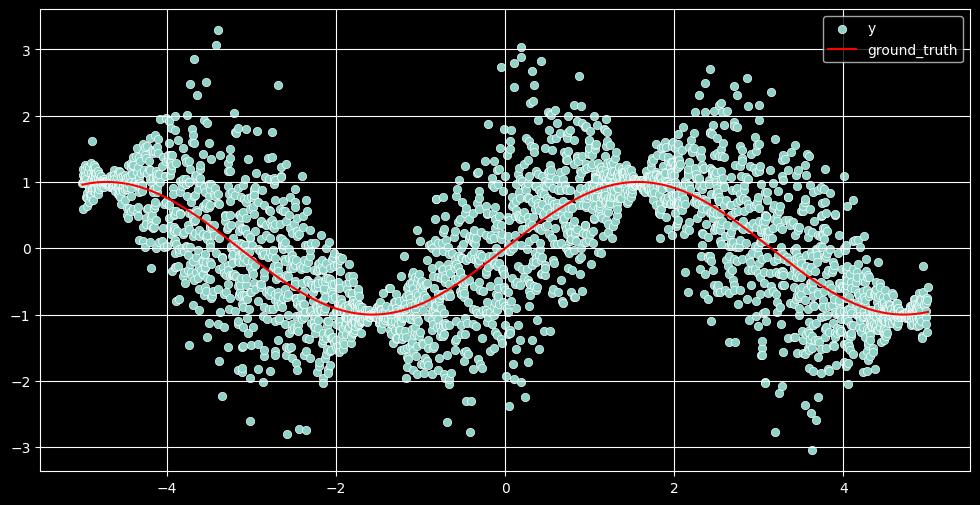

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(
    x=x, y=y, ax=ax, label='y'
)
sns.lineplot(
    x=x, y=ground_truth, ax=ax, label='ground_truth', color='red'
)
ax.grid()
ax.legend()

/var/folders/rm/t0n_97t93xs7p36nmjy84ddw0000gn/T/ipykernel_59184/4181605868.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


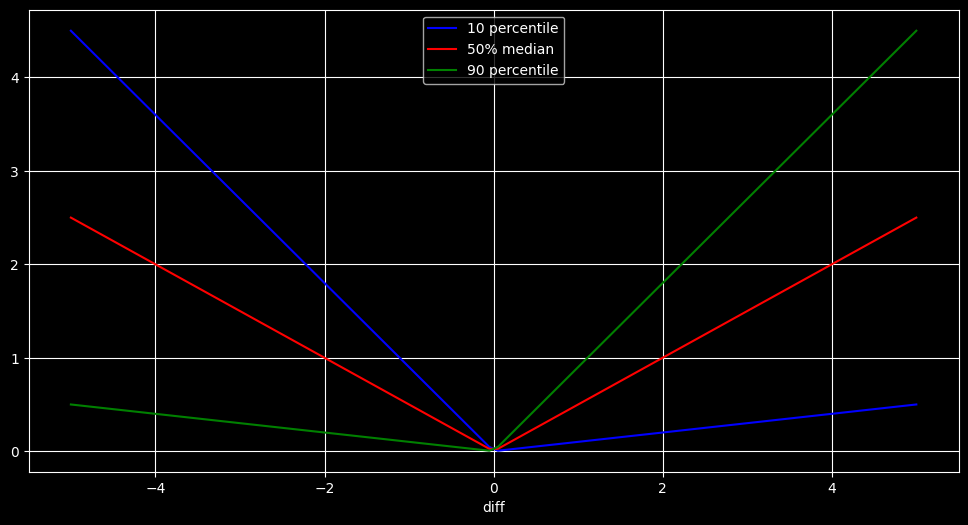

In [12]:
alphas = [0.1, 0.5, 0.9]
colors = ['blue', 'red', 'green']
labels = ['10 percentile', '50% median', "90 percentile"]

def get_pinball_loss(y_diff: float, alpha: float):
    if y_diff > 0:
        return y_diff * alpha
    else:
        return -y_diff * (1 - alpha)

y_diffs = np.linspace(-5, 5, 100)
fig, ax = plt.subplots(figsize=(12,6))
for i, alpha in enumerate(alphas):
    color = colors[i]
    label = labels[i]
    pinball_loss = [
        get_pinball_loss(y_diff, alpha) for y_diff in y_diffs 
    ]
    sns.lineplot(
        x=y_diffs, 
        y=pinball_loss, 
        label=label, 
        color=color,
        ax=ax
    )
ax.grid()
ax.set_xlabel('diff')
fig.show()

In [13]:
lower_quantile = 0.025
upper_quantile = 0.975

predict_dict = {}
for quantile in [lower_quantile, upper_quantile]:
    quantile_params = {
        "objective": "quantile", # quantile を指定することで分位点予測となる。
        "alpha": quantile # alpha には分位点の値を指定する。
    }
    quantile_regressor = lgbm.train(
        quantile_params,
        lgbm.Dataset(x_for_lgbm, y_for_lgbm),
    )
    quantile_predict = quantile_regressor.predict(x_for_lgbm)
    predict_dict[quantile] = quantile_predict

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 1
[LightGBM] [Info] Start training from score -1.697950
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 1
[LightGBM] [Info] Start training from score 1.786490


/var/folders/rm/t0n_97t93xs7p36nmjy84ddw0000gn/T/ipykernel_59184/3280813124.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


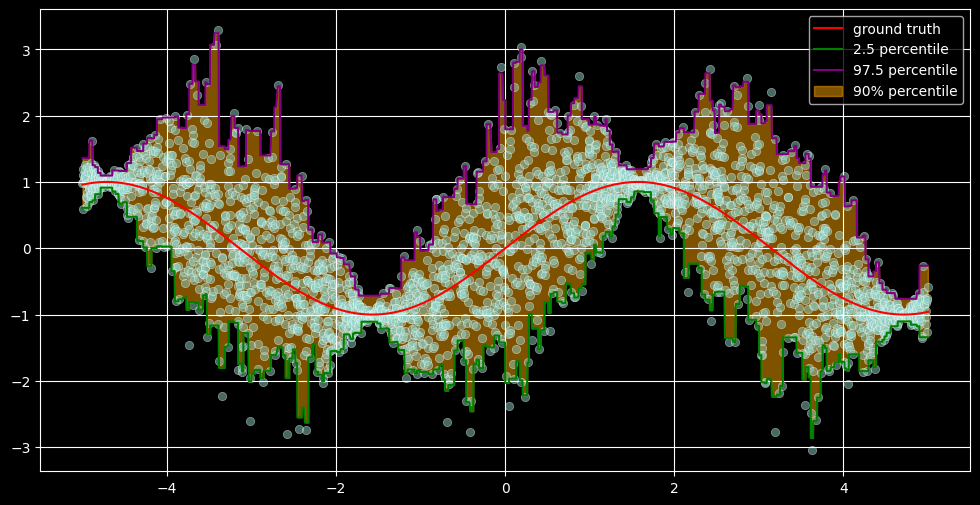

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
# ground truth
ax.plot(x, ground_truth, c='red', label='ground truth')
# 2.5% 分位予測
ax.plot(x, predict_dict[lower_quantile], c='green', label=f'{lower_quantile*100:.1f} percentile')
# 97.5% 分位予測
ax.plot(x, predict_dict[upper_quantile], c='purple', label=f'{upper_quantile*100:.1f} percentile')

# 描画で指定している alpha は透明度です。
ax.fill_between(
    x, 
    predict_dict[lower_quantile],
    predict_dict[upper_quantile],
    color='orange',
    alpha = 0.5,
    label='90% percentile'
)

sns.scatterplot(x=x,y=y,ax=ax, alpha=0.5)
ax.grid()
ax.legend()
fig.show()

In [16]:
upper = predict_dict[upper_quantile]
lower = predict_dict[lower_quantile]
total = 0
for i in range(num_of_sample):
    upper_i = upper[i]
    lower_i = lower[i]
    y_i = y[i]
    # 区間内に含まれたデータの数をカウント
    total += (lower_i <= y_i <= upper_i)

# 割合を計算する。
print(total/num_of_sample)

0.946
